# Machine Learning-Based Drought Forecasting Model Utilizing Meteorological Data

### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, 
    precision_score, recall_score, f1_score, cohen_kappa_score, 
    mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, 
    roc_curve
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from scipy.stats import pearsonr
from statsmodels.tsa.arima.model import ARIMA
import torch.nn.functional as F

### Reading Input Data

In [3]:
# Read input data
data = pd.read_csv("C:/Users/hp/Desktop/Project-1/Dataset/archive/train_timeseries/train_timeseries.csv")
data.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN


### Data Preprocessing

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19300680 entries, 0 to 19300679
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 3.0+ GB


In [5]:
data.isnull().sum()

fips                  0
date                  0
PRECTOT               0
PS                    0
QV2M                  0
T2M                   0
T2MDEW                0
T2MWET                0
T2M_MAX               0
T2M_MIN               0
T2M_RANGE             0
TS                    0
WS10M                 0
WS10M_MAX             0
WS10M_MIN             0
WS10M_RANGE           0
WS50M                 0
WS50M_MAX             0
WS50M_MIN             0
WS50M_RANGE           0
score          16543884
dtype: int64

In [6]:
# Removing the null values in the target variable as the drought score is only available for once in 7 days.
data = data.dropna()
data.isnull().sum()

fips           0
date           0
PRECTOT        0
PS             0
QV2M           0
T2M            0
T2MDEW         0
T2MWET         0
T2M_MAX        0
T2M_MIN        0
T2M_RANGE      0
TS             0
WS10M          0
WS10M_MAX      0
WS10M_MIN      0
WS10M_RANGE    0
WS50M          0
WS50M_MAX      0
WS50M_MIN      0
WS50M_RANGE    0
score          0
dtype: int64

In [7]:
data.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score          float64
dtype: object

In [8]:
# Data Wrangling
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month
data['day'] = pd.DatetimeIndex(data['date']).day
data['score'] = data['score'].round().astype(int)
data.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score            int32
year             int32
month            int32
day              int32
dtype: object

In [9]:
data['fips'].nunique()

3108

In [10]:
data['score'].round().value_counts()

score
0    1652230
1     466944
2     295331
3     196802
4     106265
5      39224
Name: count, dtype: int64

### Exploratory Data Analysis

In [11]:
# Descriptive statistics
display(data.describe())  # For numeric columns
display(data.describe(include=['object']))  # For categorical columns
# Calculate skewness and kurtosis only for numeric columns
numeric_data = data.select_dtypes(include=['number'])  # Select only numeric columns
print("\nSkewness: \n", numeric_data.skew(axis=0, skipna=True))
print("\nKurtosis: \n", numeric_data.kurtosis(axis=0, skipna=True))

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,year,month,day
count,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,...,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06
mean,3.067038e+04,2.714566e+00,9.664736e+01,7.875770e+00,1.289923e+01,7.049350e+00,7.084938e+00,1.876711e+01,7.519916e+00,1.124720e+01,...,1.920655e+00,3.282268e+00,5.532799e+00,7.828799e+00,3.121578e+00,4.707223e+00,8.231266e-01,2.007999e+03,6.520857e+00,1.568997e+01
std,1.497911e+04,6.247590e+00,5.444698e+00,4.721459e+00,1.097040e+01,1.019765e+01,1.014364e+01,1.160295e+01,1.061818e+01,4.038022e+00,...,1.342458e+00,1.943136e+00,2.298550e+00,2.836618e+00,2.109945e+00,2.181020e+00,1.239070e+00,4.897714e+00,3.447033e+00,8.798878e+00
min,1.001000e+03,0.000000e+00,6.649000e+01,1.400000e-01,-3.544000e+01,-3.544000e+01,-3.546000e+01,-3.003000e+01,-4.085000e+01,1.600000e-01,...,0.000000e+00,2.600000e-01,5.100000e-01,8.500000e-01,0.000000e+00,4.200000e-01,0.000000e+00,2.000000e+03,1.000000e+00,1.000000e+00
25%,1.904450e+04,0.000000e+00,9.583000e+01,3.810000e+00,4.580000e+00,-8.800000e-01,-8.400000e-01,1.036000e+01,-5.700000e-01,8.370000e+00,...,9.600000e-01,1.820000e+00,3.820000e+00,5.700000e+00,1.450000e+00,3.140000e+00,0.000000e+00,2.004000e+03,4.000000e+00,8.000000e+00
50%,2.921200e+04,1.900000e-01,9.828000e+01,6.940000e+00,1.421000e+01,7.810000e+00,7.810000e+00,2.062000e+01,8.260000e+00,1.120000e+01,...,1.660000e+00,2.820000e+00,5.150000e+00,7.350000e+00,2.770000e+00,4.270000e+00,0.000000e+00,2.008000e+03,7.000000e+00,1.600000e+01
75%,4.600750e+04,2.260000e+00,9.994000e+01,1.145000e+01,2.200000e+01,1.567000e+01,1.567000e+01,2.797000e+01,1.628000e+01,1.408000e+01,...,2.570000e+00,4.280000e+00,6.880000e+00,9.490000e+00,4.390000e+00,5.810000e+00,1.000000e+00,2.012000e+03,1.000000e+01,2.300000e+01
max,5.604300e+04,1.686900e+02,1.037600e+02,2.212000e+01,3.933000e+01,2.687000e+01,2.687000e+01,4.775000e+01,3.228000e+01,3.017000e+01,...,1.462000e+01,1.872000e+01,2.247000e+01,2.833000e+01,1.778000e+01,2.337000e+01,5.000000e+00,2.016000e+03,1.200000e+01,3.100000e+01


,date
count,2756796
unique,887
top,2000-01-04
freq,3108



Skewness: 
 fips          -0.077367
PRECTOT        4.568803
PS            -2.132573
QV2M           0.526605
T2M           -0.426059
T2MDEW        -0.302684
T2MWET        -0.289061
T2M_MAX       -0.467449
T2M_MIN       -0.365648
T2M_RANGE      0.092413
TS            -0.396537
WS10M          1.112524
WS10M_MAX      0.931888
WS10M_MIN      1.400951
WS10M_RANGE    1.287969
WS50M          0.861690
WS50M_MAX      0.899830
WS50M_MIN      0.860444
WS50M_RANGE    1.214403
score          1.498394
year          -0.000183
month         -0.008198
day            0.006969
dtype: float64

Kurtosis: 
 fips           -1.100136
PRECTOT        33.304567
PS              4.813301
QV2M           -0.786067
T2M            -0.554336
T2MDEW         -0.733896
T2MWET         -0.758504
T2M_MAX        -0.508101
T2M_MIN        -0.446940
T2M_RANGE      -0.316984
TS             -0.535722
WS10M           1.419724
WS10M_MAX       0.705953
WS10M_MIN       3.159288
WS10M_RANGE     2.084432
WS50M           0.819908
WS50M_M

In [12]:
column_list = list(data.columns)
column_list

['fips',
 'date',
 'PRECTOT',
 'PS',
 'QV2M',
 'T2M',
 'T2MDEW',
 'T2MWET',
 'T2M_MAX',
 'T2M_MIN',
 'T2M_RANGE',
 'TS',
 'WS10M',
 'WS10M_MAX',
 'WS10M_MIN',
 'WS10M_RANGE',
 'WS50M',
 'WS50M_MAX',
 'WS50M_MIN',
 'WS50M_RANGE',
 'score',
 'year',
 'month',
 'day']

In [13]:
# Univariate Analysis
measures_column_list = ['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']
drought_df_measures = data[['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']]

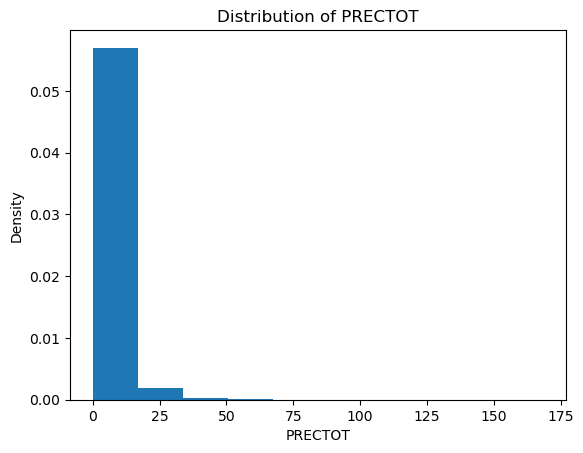

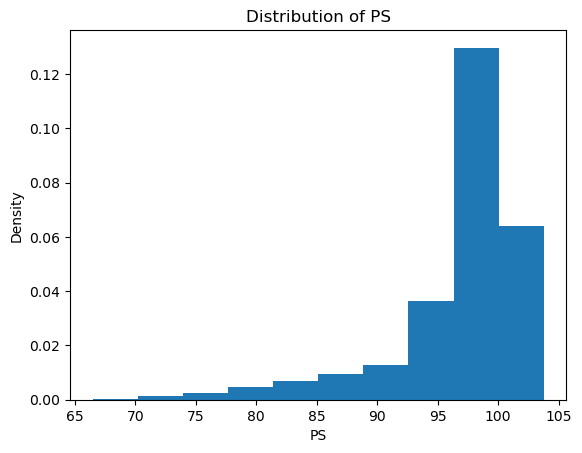

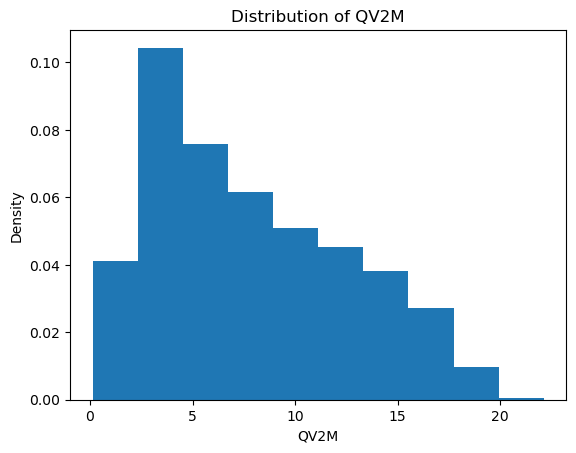

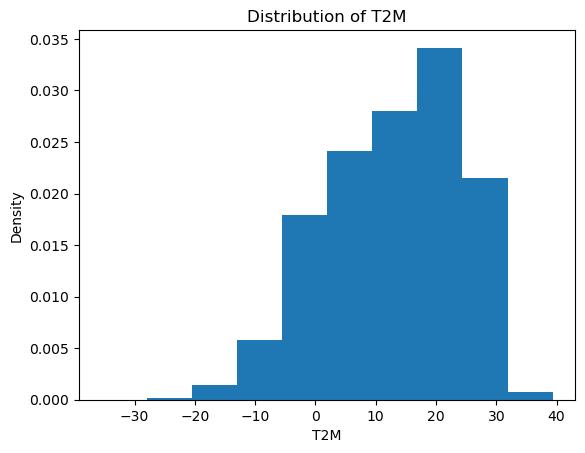

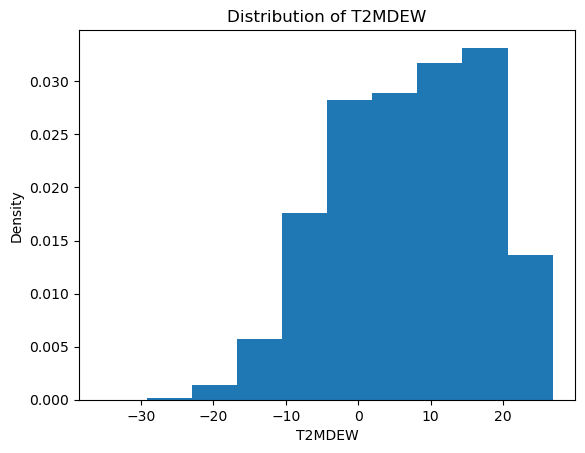

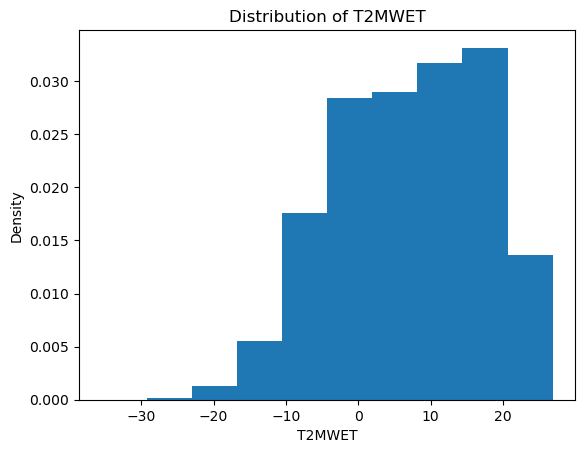

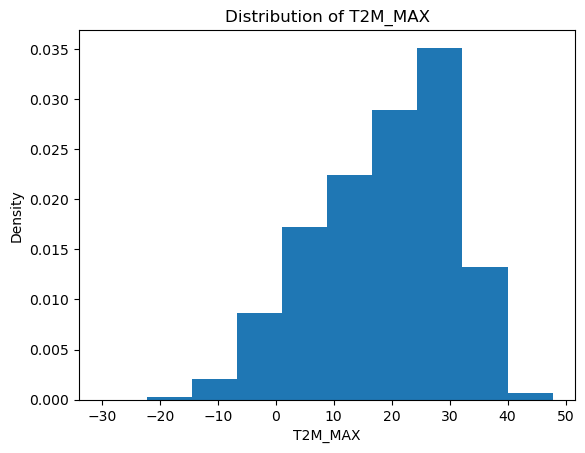

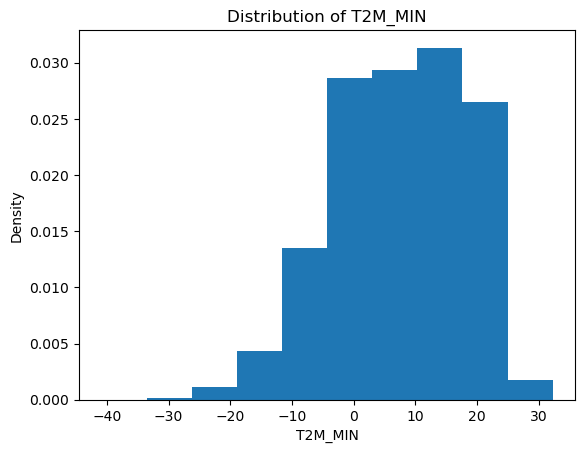

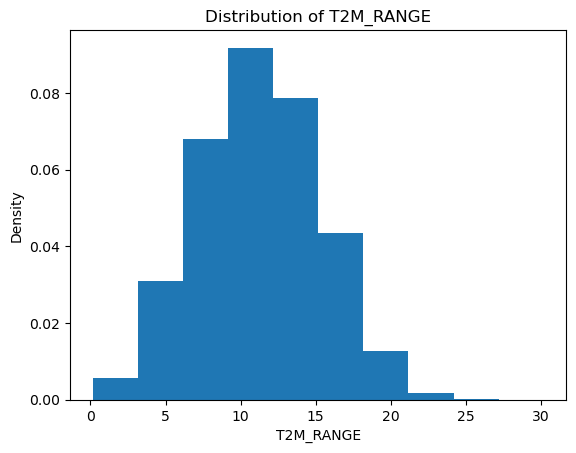

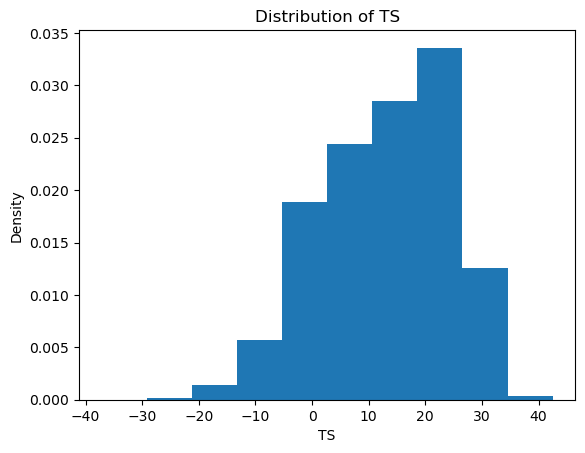

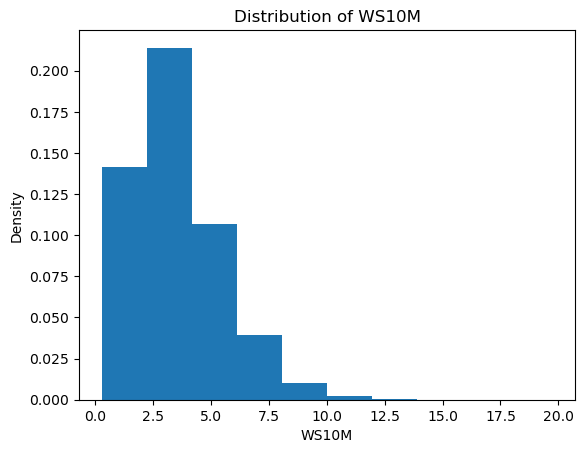

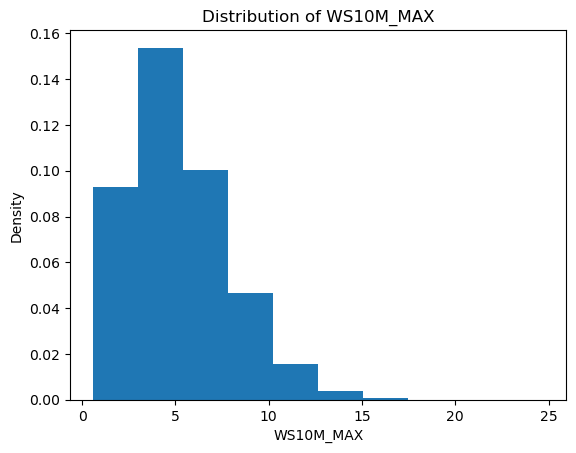

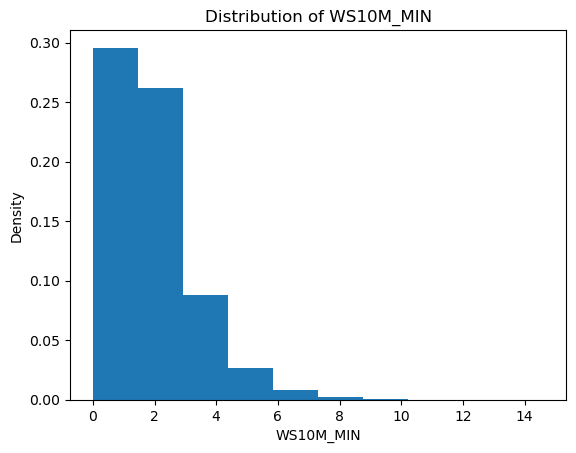

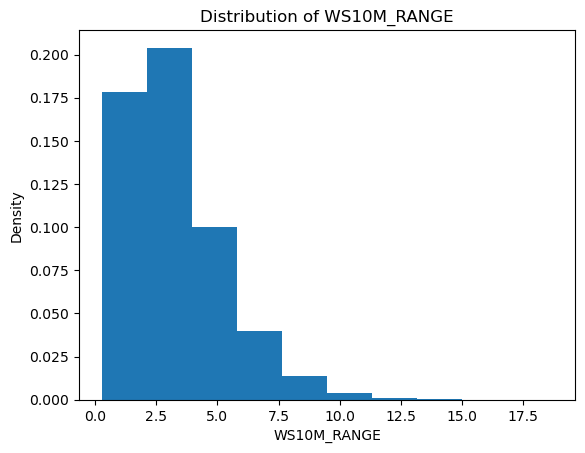

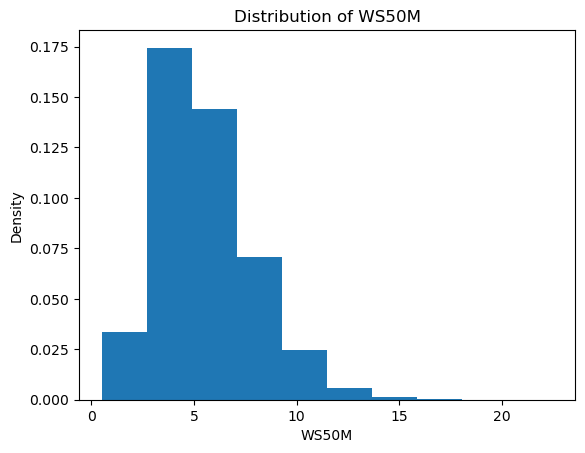

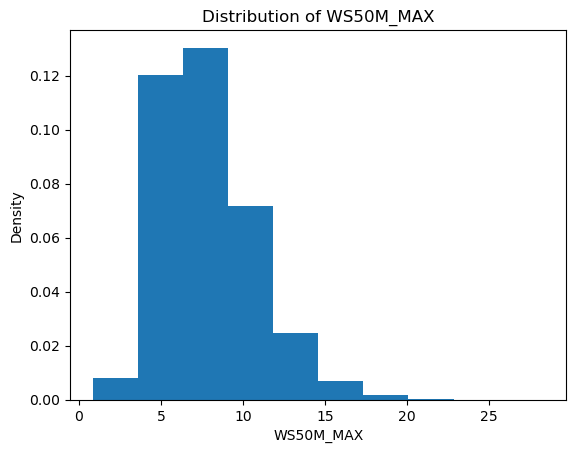

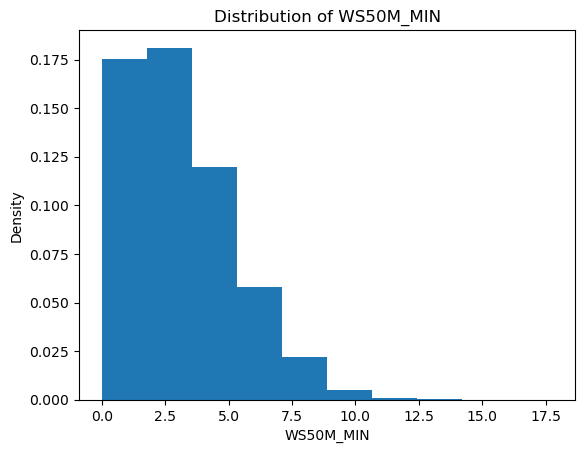

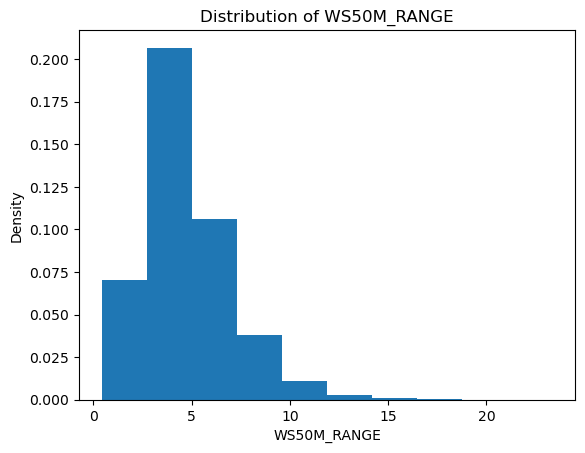

In [14]:
for col_name in measures_column_list:
    plt.figure()
    plt.hist(drought_df_measures[col_name], density = True)
    x_name = col_name
    plt.xlabel(x_name)
    y_name = 'Density'
    plt.ylabel(y_name)
    plt.title('Distribution of {x_name}'.format(x_name=x_name))

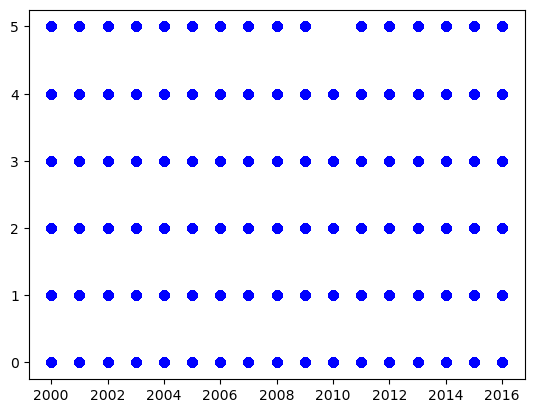

In [15]:
# Bivariate Analysis
plt.scatter(data['year'], data['score'], c ="blue")
plt.show()

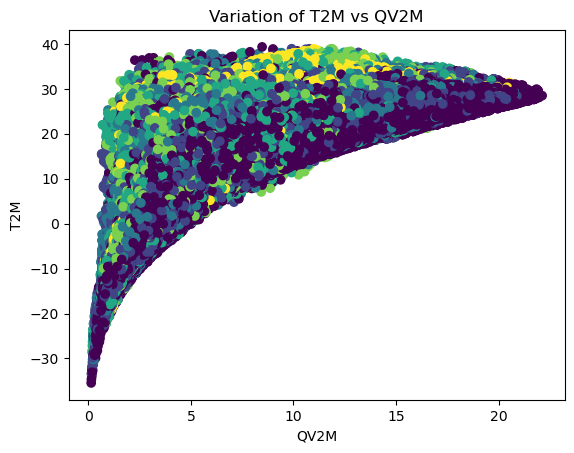

In [16]:
plt.scatter(data['QV2M'], data['T2M'], c =data['score'])
plt.xlabel('QV2M')
plt.ylabel('T2M')
plt.title('Variation of T2M vs QV2M')
plt.show()

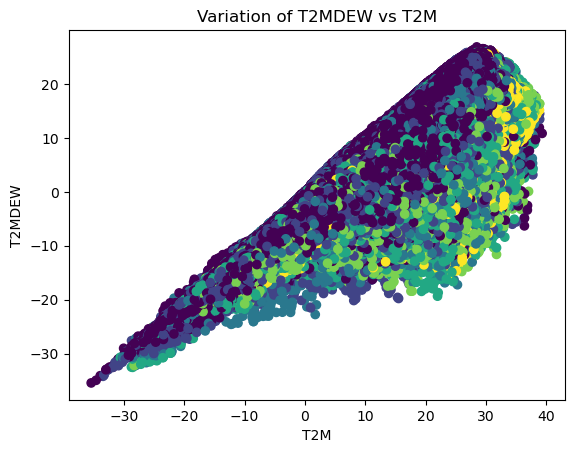

In [17]:
plt.scatter(data['T2M'], data['T2MDEW'], c =data['score'])
plt.xlabel('T2M')
plt.ylabel('T2MDEW')
plt.title('Variation of T2MDEW vs T2M')
plt.show()

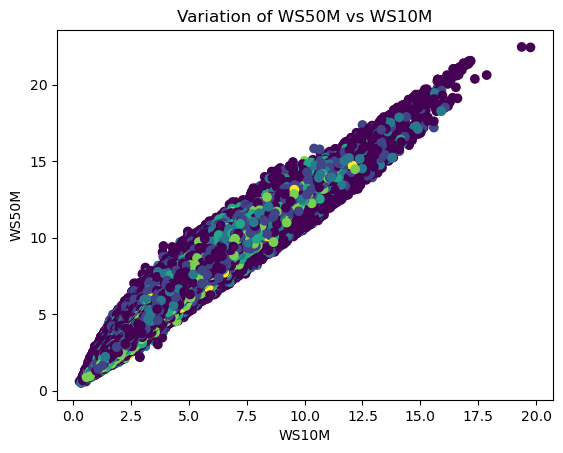

In [18]:
temp_df = data[data['score']==5]
plt.scatter(data['WS10M'], data['WS50M'], c= data['score'])
plt.xlabel('WS10M')
plt.ylabel('WS50M')
plt.title('Variation of WS50M vs WS10M')
plt.show()

### Extracting Dependent and Independent Variables

In [19]:
independent_variables = data.drop('score', axis=1)
independent_variables = independent_variables.drop('fips', axis=1)
independent_variables = independent_variables.drop('date', axis=1)
independent_variables.head()

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,year,month,day
3,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,15.92,11.31,...,5.67,2.08,3.59,6.73,9.31,3.74,5.58,2000,1,4
10,1.33,100.40,6.63,11.48,7.84,7.84,18.88,5.72,13.16,10.43,...,2.48,1.05,1.43,3.55,6.38,1.71,4.67,2000,1,11
17,1.11,100.39,9.53,14.28,13.26,13.26,18.04,8.98,9.06,14.19,...,3.60,1.67,1.92,5.19,6.40,3.84,2.55,2000,1,18
24,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,-5.46,11.11,-0.61,...,4.59,2.28,2.32,5.75,8.03,3.96,4.07,2000,1,25
31,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,15.23,1.88,...,2.74,0.88,1.86,4.18,6.38,1.27,5.11,2000,2,1


In [20]:
target = data['score']
target.head()

3     1
10    2
17    2
24    2
31    1
Name: score, dtype: int32

### Correlation Between Independent Variables For Feature Selection

In [21]:
correlation_plot = drought_df_measures.corr()
correlation_plot.style.background_gradient(cmap = 'RdYlGn')

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
PRECTOT,1.000000,0.068775,0.245081,0.093258,0.231035,0.230975,0.026773,0.144929,-0.304171,0.089598,0.049730,0.060981,0.023346,0.065755,0.069057,0.079508,0.057816,0.047477
PS,0.068775,1.000000,0.282412,0.164160,0.341234,0.341252,0.111979,0.208285,-0.225935,0.163830,-0.080747,-0.135905,0.022932,-0.198332,-0.043315,-0.091821,0.036238,-0.154479
QV2M,0.245081,0.282412,1.000000,0.870242,0.959385,0.960434,0.804338,0.906144,-0.071547,0.862559,-0.225449,-0.256452,-0.108789,-0.269203,-0.205971,-0.249961,-0.081554,-0.246203
T2M,0.093258,0.164160,0.870242,1.000000,0.913530,0.914218,0.983356,0.981629,0.244357,0.997515,-0.207874,-0.220192,-0.125407,-0.209030,-0.193196,-0.206444,-0.112579,-0.159589
T2MDEW,0.231035,0.341234,0.959385,0.913530,1.000000,0.999970,0.854716,0.939934,-0.015643,0.905184,-0.238299,-0.268686,-0.115920,-0.280702,-0.204238,-0.245323,-0.082416,-0.239335
T2MWET,0.230975,0.341252,0.960434,0.914218,0.999970,1.000000,0.855401,0.940629,-0.015500,0.905911,-0.237971,-0.268292,-0.115882,-0.280199,-0.204143,-0.245147,-0.082497,-0.239029
T2M_MAX,0.026773,0.111979,0.804338,0.983356,0.854716,0.855401,1.000000,0.937762,0.407534,0.980101,-0.216764,-0.221671,-0.141911,-0.199614,-0.195727,-0.196236,-0.133234,-0.126331
T2M_MIN,0.144929,0.208285,0.906144,0.981629,0.939934,0.940629,0.937762,1.000000,0.065037,0.979134,-0.206382,-0.225829,-0.112878,-0.225256,-0.197991,-0.225744,-0.096593,-0.200157
T2M_RANGE,-0.304171,-0.225935,-0.071547,0.244357,-0.015643,-0.015500,0.407534,0.065037,1.000000,0.241564,-0.080163,-0.043127,-0.110952,0.018746,-0.041778,0.029737,-0.128844,0.163320
TS,0.089598,0.163830,0.862559,0.997515,0.905184,0.905911,0.980101,0.979134,0.241564,1.000000,-0.189823,-0.202713,-0.110273,-0.196015,-0.180665,-0.193347,-0.102367,-0.152434


### Splitting Data Into Train and Test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(independent_variables, target, test_size=0.2, random_state=0)

In [23]:
print("Train features shape", X_train.shape)
print("Train target shape", y_train.shape)
print("Test features shape", X_test.shape)
print("Test target shape", y_test.shape)

Train features shape (2205436, 21)
Train target shape (2205436,)
Test features shape (551360, 21)
Test target shape (551360,)


### Standardizing The Data

In [24]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train

array([[ 2.21714261e+00,  9.57089223e-02,  1.50081031e+00, ...,
         2.04741496e-01,  1.00934752e+00, -3.05953840e-01],
       [-4.34665774e-01, -7.40190517e-01, -1.13222167e+00, ...,
        -1.02000952e+00, -1.31156897e+00, -5.33260874e-01],
       [-3.89747060e-01,  7.49731341e-01,  1.64061732e+00, ...,
         4.08866666e-01, -1.51110728e-01, -7.86468057e-02],
       ...,
       [-2.72637555e-01, -1.48423288e+00, -9.16156290e-01, ...,
        -6.11759181e-01, -1.31156897e+00, -1.66979604e+00],
       [-4.34665774e-01, -3.65652748e-02, -3.29390515e-01, ...,
         6.16326886e-04,  7.19232955e-01,  3.50067113e-02],
       [-3.88142820e-01,  9.73862619e-01,  2.25600940e-01, ...,
         6.12991835e-01, -1.02145441e+00, -8.74221425e-01]])

### Model Development

In [ ]:
# Step 1: Train ARIMA model on train data for each time series
def train_arima(series, order=(1, 1, 1)):
    arima_model = ARIMA(series, order=order)
    arima_result = arima_model.fit()
    return arima_result

# Apply ARIMA on each feature in X_train and collect predictions
X_train = pd.DataFrame(X_train)
num_columns = X_train.shape[1]
arima_train_predictions = []
arima_test_predictions = []

for col_idx in range(num_columns):
    train_series = X_train.iloc[:, col_idx]
    arima_train = train_arima(train_series.values)
    arima_train_predictions.append(arima_train.predict(start=0, end=len(train_series) - 1))
    arima_test_predictions.append(arima_train.predict(start=len(train_series), end=len(train_series) + len(X_test) - 1))

arima_train_predictions = np.array(arima_train_predictions).T
arima_test_predictions = np.array(arima_test_predictions).T

In [ ]:
# Step 2: Define TCN model
class TCN(nn.Module):
    def __init__(self, input_channels, hidden_dim, output_channels, kernel_size, num_layers):
        super(TCN, self).__init__()
        self.tcn_layers = nn.ModuleList()
        self.tcn_layers.append(nn.Conv1d(input_channels, hidden_dim, kernel_size, padding=1))
        
        for _ in range(1, num_layers - 1):
            self.tcn_layers.append(nn.Conv1d(hidden_dim, hidden_dim, kernel_size, padding=1))
        
        self.tcn_layers.append(nn.Conv1d(hidden_dim, output_channels, kernel_size, padding=1))
        self.fc = nn.Linear(output_channels, 1)

    def forward(self, x):
        for layer in self.tcn_layers:
            x = torch.relu(layer(x))
        x = x[:, :, -1]
        x = self.fc(x)
        return x

# Model hyperparameters
input_channels = 1
hidden_dim = 16
output_channels = 1
kernel_size = 2
num_layers = 3

# Initialize the TCN model
tcn_model = TCN(input_channels, hidden_dim, output_channels, kernel_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(tcn_model.parameters(), lr=0.001)

# Convert ARIMA predictions and target to PyTorch tensors
X_train_tcn = torch.tensor(arima_train_predictions, dtype=torch.float32).unsqueeze(1)
y_train_tcn = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tcn = torch.tensor(arima_test_predictions, dtype=torch.float32).unsqueeze(1)
y_test_tcn = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tcn, y_train_tcn)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [15]:
# Step 3: Train the TCN Model
epochs = 30
for epoch in range(epochs):
    tcn_model.train()
    epoch_loss = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = tcn_model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1/30, Loss: 0.1465
Epoch 2/30, Loss: 0.1438
Epoch 3/30, Loss: 0.1427
Epoch 4/30, Loss: 0.1419
Epoch 5/30, Loss: 0.1414
Epoch 6/30, Loss: 0.1409
Epoch 7/30, Loss: 0.1406
Epoch 8/30, Loss: 0.1402
Epoch 9/30, Loss: 0.1400
Epoch 10/30, Loss: 0.1398
Epoch 11/30, Loss: 0.1396
Epoch 12/30, Loss: 0.1395
Epoch 13/30, Loss: 0.1393
Epoch 14/30, Loss: 0.1392
Epoch 15/30, Loss: 0.1391
Epoch 16/30, Loss: 0.1390
Epoch 17/30, Loss: 0.1389
Epoch 18/30, Loss: 0.1388
Epoch 19/30, Loss: 0.1387
Epoch 20/30, Loss: 0.1386
Epoch 21/30, Loss: 0.1386
Epoch 22/30, Loss: 0.1385
Epoch 23/30, Loss: 0.1385
Epoch 24/30, Loss: 0.1384
Epoch 25/30, Loss: 0.1384
Epoch 26/30, Loss: 0.1383
Epoch 27/30, Loss: 0.1382
Epoch 28/30, Loss: 0.1382
Epoch 29/30, Loss: 0.1381
Epoch 30/30, Loss: 0.1382


ARIMA-TCN Model
Confusion Matrix:
 [[2063  207   38    0    0    0]
 [  83  196   51    6    0    0]
 [  14   42   68   13    1    0]
 [   1    5    5   26    8    0]
 [   0    0    1    6   20    4]
 [   0    0    0    0    1   14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92      2308
           1       0.44      0.58      0.50       336
           2       0.42      0.49      0.45       138
           3       0.51      0.58      0.54        45
           4       0.67      0.65      0.66        31
           5       0.78      0.93      0.85        15

    accuracy                           0.83      2873
   macro avg       0.63      0.69      0.65      2873
weighted avg       0.86      0.83      0.84      2873

Accuracy: 0.8308388444135051
Precision: 0.8571268257745605
Recall: 0.8308388444135051
F1 Score: 0.8417033154312398
Cohen Kappa Score: 0.548035316143968
Mean Squared Error: 0.2398190045248869
Mean Abs

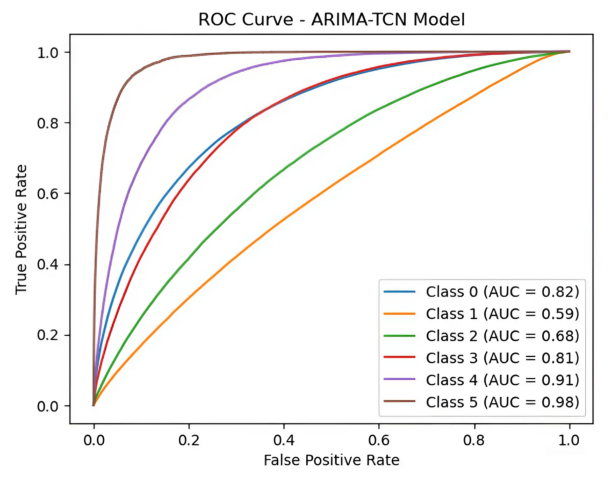

In [40]:
def evaluate_tcn_model(model, X_test_tcn, y_test_tcn, model_name):
    predictions = model(X_test_tcn).detach().numpy()
    y_pred = predictions.argmax(axis=1)
    
    # Metrics
    print(f"{model_name}")
    print("Confusion Matrix:\n", confusion_matrix(y_test_tcn, y_pred))
    print("Classification Report:\n", classification_report(y_test_tcn, y_pred))
    print("Accuracy:", accuracy_score(y_test_tcn, y_pred))
    print("Precision:", precision_score(y_test_tcn, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test_tcn, y_pred, average='weighted'))
    print("F1 Score:", f1_score(y_test_tcn, y_pred, average='weighted'))
    print("Cohen Kappa Score:", cohen_kappa_score(y_test_tcn, y_pred))
    print("Mean Squared Error:", mean_squared_error(y_test_tcn, y_pred))
    print("Mean Absolute Error:", mean_absolute_error(y_test_tcn, y_pred))
    print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test_tcn, y_pred)))
    print("R-squared:", r2_score(y_test_tcn, y_pred))

    # ROC Curve for multi-class
    y_test_bin = label_binarize(y_test_tcn, classes=np.unique(y_test_tcn))
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test_tcn)
    else:
        probs = model(X_test_tcn).detach().numpy()
        
    # Compute ROC and AUC for each class
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs[:, i])
        auc_score = roc_auc_score(y_test_bin[:, i], probs[:, i])
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_score:.2f})")
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="best")
    plt.show()

# Evaluate the TCN model
evaluate_tcn_model(tcn_model, X_test_tcn, y_test_tcn, "ARIMA-TCN Model")